In [80]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
from IPython.display import HTML
import networkx as nx


from numpy.fft import fft, ifft, fftfreq

from scipy.spatial.distance import pdist, squareform
from scipy.stats import rankdata, ttest_rel, ttest_1samp, pearsonr, spearmanr
from scipy.signal import hilbert


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf
from nilearn.image import new_img_like

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score, permutation_test_score
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, pairwise_distances
from imblearn.over_sampling import SMOTE 

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')


# brain & behaviar data

In [82]:

base_dir = '/Users/li/Desktop/debate/braindata'

sub_list = [f'sub-{x:0>3d}' for x in range(13,51)]
sub_list.remove('sub-021')

subs_roi_data = []
for sub in sub_list:
    csv_file = f'/Volumes/Li/task-debate/braindata/denoised 5/parcel data/Schaefer 200 combine 6 runs/{sub}_combined_time-series_Schaefer2018_200Parcels_7Networks.csv'
    sub_data = pd.read_csv(csv_file)
    subs_roi_data.append(sub_data.values)

all_brain_data = np.array(subs_roi_data)

mask_file = '/Users/li/Desktop/template/Schaefer/tpl-MNI152NLin2009cAsym_res-02_atlas-Schaefer2018_desc-200Parcels7Networks_dseg.nii.gz'
mask_img = nib.load(mask_file)
mask_data = mask_img.get_fdata()

nw_labels = pd.read_csv('/Users/li/Desktop/template/Schaefer/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
roi_name = list(nw_labels['ROI Name'])


In [84]:

## 态度变化
bahav_data_dir = '/Users/li/Desktop/task-debate/behavdata'
sub_list_num = list(range(13,51))
sub_list_num.remove(21)

# time_points = list(range(0,3000,60)) + [2986]  # every minute
time_points = list(range(0,3000,120)) + [2986] # every 2min

# [0,120,240,
#  360,480,
#  600,720,
#  840,960,1080,
#  1200,1320,1440,
#  1560,1680,1800,
#  1920,2040,2160,2280,2400,
#  2520,2640,2760,2880,3000]

# [0,120,252,
#  360,480,
#  600,720,
#  840,960,1080,
#  1200,1320,1440,
#  1560,1680,1800,
#  1920,2040,2160,2280,2400,
#  2520,2640,2760,2880,3000]
 
# time_points = [0, 252, 500, 772, 1098, 1484, 1892, 2464, 2986]
# time_points = list(range(0,2987,2)) # every TR
# time_points = [0,80,168,208,252, 
#                326,364,464,500,
#                538,588,686,772,
#                860,986,1026,1098,
#                1204,1250,1406,1484,
#                1578,1722,1810,1892,
#                1972,2114,2216,2464,
#                2628,2756,2986] 
# time_point = [ int(x-2) for x in time_points]

all_subject_data = []
for sub in sub_list_num:
    file_path = os.path.join(bahav_data_dir, 'during_scan', 'combined_6runs_per_TR_filter', f'subject_{sub}_TR_rate.csv')
    
    df = pd.read_csv(file_path)
    sub_data = df[df['time'].isin(time_points)]
    all_subject_data.append(list(sub_data['rate']))
    
start_attitude = pd.DataFrame(all_subject_data)[0]
start_attitude_SM = -np.abs(start_attitude.values[:, np.newaxis] - start_attitude.values) 

attitude = pd.DataFrame(all_subject_data) 
attitude_change = attitude.diff(axis=1)
attitude_change = attitude_change.drop(attitude_change.columns[0], axis=1)
attitude_change_distances = -pdist(attitude_change)
attitude_change_distances_matrix = squareform(attitude_change_distances)

# 性别与年龄

personality = pd.read_csv('/Users/li/Desktop/task-debate/behavdata/questionire_data/personality.csv')
selected_data = personality[personality['sub'].isin(sub_list_num)]
selected_data = selected_data.set_index('sub').loc[sub_list_num]
ages = selected_data['age'].values
age_diff_matrix = np.abs(ages[:, np.newaxis] - ages)
sex = selected_data['sex'].values
sex_diff_matrix = np.abs(sex[:, np.newaxis] - sex)


In [86]:
TR_points = [round(x/2) for x in time_points]
attitude = np.array(attitude)

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)


# every 2 min

## change or not?



____________seed 89______________
 samples 925
置换检验得分: 0.66
置换检验的p值: 0.0010
混淆矩阵:
[[324 174]
 [139 288]]
分类报告:
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       498
           1       0.62      0.67      0.65       427

    accuracy                           0.66       925
   macro avg       0.66      0.66      0.66       925
weighted avg       0.66      0.66      0.66       925



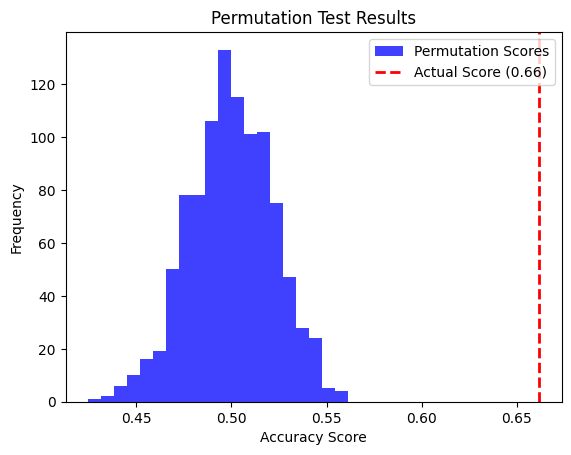

In [20]:
def set_y(row):
    if row['change'] != 0:
        return 1
    else:
        return 0
        
seeds_index_list = [89]
data = all_brain_data

brain_area_index = 89
results = []
for i in range(len(TR_points) - 1):
    start = TR_points[i]
    end = TR_points[i + 1]
    
    # 提取每个被试在当前时间段的数据
    for subject in range(data.shape[0]):
        segment = data[subject, start:end, :]
        
        # 计算功能连接
        correlation_matrix = np.corrcoef(segment, rowvar=False)
        correlations = correlation_matrix[brain_area_index, :]
        correlations = np.delete(correlations, brain_area_index)

        begin_attitude = attitude[subject, i]
        after_attitude = attitude[subject, i+1]
        change = after_attitude - begin_attitude
        # 存储结果
        results.append({
            'subject': subject,
            'time_segment': i,
            'connectivity': correlations,
            'begin_attitude': begin_attitude,
            'after_attitude': after_attitude,
            'change': change,
            'type': None})
# 创建功能连接的 DataFrame
df = pd.DataFrame(results)
df = df.drop(columns='connectivity').join(pd.DataFrame(df['connectivity'].tolist(), index=df.index)) 
df_expanded = df.copy()      
df_expanded['type'] = df_expanded.apply(set_y, axis=1)
df_expanded = df_expanded.dropna(subset=['type'])

print(f'\n\n____________seed {seed_indes}______________\n samples',df_expanded.shape[0])
X = df_expanded.drop(columns=['subject', 'time_segment', 'begin_attitude', 'after_attitude', 'change','type'])  # 特征是功能连接的列
y = df_expanded['type']  # 目标是态度数据

svm_model = SVC(class_weight='balanced')
score, permutation_scores, pvalue = permutation_test_score(
    svm_model, X, y, cv=kfold, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)

print(f"置换检验得分: {score:.2f}")
print(f"置换检验的p值: {pvalue:.4f}")

y_pred = cross_val_predict(svm_model, X, y, cv=loo)
accuracy = accuracy_score(y, y_pred)
# 计算混淆矩阵
conf_matrix = confusion_matrix(y, y_pred)

# 输出混淆矩阵
print("混淆矩阵:")
print(conf_matrix)

# 输出详细的分类报告（精确率、召回率、F1-score）
print("分类报告:")
print(classification_report(y, y_pred))

# 可视化置换检验结果
plt.hist(permutation_scores, bins=20, alpha=0.75, color='blue', label='Permutation Scores')
plt.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Actual Score ({score:.2f})')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('Permutation Test Results')
plt.legend(loc='best')
plt.show()

In [89]:

attitude_np = []
for sub in sub_list_num:
    file_path = os.path.join(bahav_data_dir, 'during_scan', 'combined_6runs_per_TR_filter', f'subject_{sub}_TR_rate.csv')
    df = pd.read_csv(file_path)
    attitude_np.append(list(df['rate']))
attitude_np = np.array(attitude_np)
print(attitude_np.shape)


# 用每行的最后一个数补齐到1500列
last_values = attitude_np[:, -1][:, np.newaxis]  # 取每行最后一个数，形状 (37, 1)
padding = np.repeat(last_values, 6, axis=1)  # 重复6次，形状 (37, 6)
data_padded = np.concatenate([attitude_np, padding], axis=1)  # 连接，得到 (37, 1500)

# 重新reshape成 (37, 25, 60)
data_reshaped = data_padded.reshape(37, 25, 60)

# 判断每组是不是所有元素一样（最大值 == 最小值）
change_result = (np.max(data_reshaped, axis=2) != np.min(data_reshaped, axis=2)).astype(int)

# result 的形状是 (37, 25)

change_result.shape

(37, 1494)


(37, 25)

In [93]:
def set_y(row):
    if row['change'] != 0:
        return 1
    else:
        return 0
        
data = all_brain_data

brain_area_index = 89
results = []
for i in range(len(TR_points) - 1):
    start = TR_points[i]
    end = TR_points[i + 1]
    
    # 提取每个被试在当前时间段的数据
    for subject in range(data.shape[0]):
        segment = data[subject, start:end, :]
        
        # 计算功能连接
        correlation_matrix = np.corrcoef(segment, rowvar=False)
        correlations = correlation_matrix[brain_area_index, :]
        correlations = np.delete(correlations, brain_area_index)

        begin_attitude = attitude[subject, i]
        after_attitude = attitude[subject, i+1]
        change = after_attitude - begin_attitude
        if_change = change_result[subject,i]
        
        # 存储结果
        results.append({
            'subject': subject,
            'time_segment': i,
            'connectivity': correlations,
            'begin_attitude': begin_attitude,
            'after_attitude': after_attitude,
            'change': change,
            'if_change': if_change,
            'type': None})
# 创建功能连接的 DataFrame
df = pd.DataFrame(results)
df = df.drop(columns='connectivity').join(pd.DataFrame(df['connectivity'].tolist(), index=df.index)) 
df_expanded = df.copy()      
df_expanded['type'] = df_expanded.apply(set_y, axis=1)
df_expanded = df_expanded.dropna(subset=['type'])

df_expanded.head()

,subject,time_segment,begin_attitude,after_attitude,change,if_change,type,0,1,2,...,189,190,191,192,193,194,195,196,197,198
0,0,0,12,12,0,0,0,-0.430392,-0.196602,-0.015653,...,0.312162,0.747290,0.667708,-0.130048,-0.198474,0.032947,0.007310,-0.073283,-0.111916,0.363747
1,1,0,10,10,0,0,0,-0.037642,-0.049698,-0.100152,...,-0.117250,0.451144,0.645362,0.380709,-0.022658,0.296430,0.039280,-0.011718,0.125541,0.025248
2,2,0,2,1,-1,1,1,-0.248057,-0.317796,-0.165081,...,-0.100692,0.220274,0.158607,0.329798,0.002796,0.145099,-0.126526,-0.242119,0.007791,0.268040
3,3,0,4,4,0,0,0,-0.174485,0.001950,0.000170,...,0.029049,0.358953,0.446784,0.204979,0.217267,0.170297,-0.400899,0.079724,-0.018689,0.094039
4,4,0,5,8,3,1,1,-0.278219,-0.211346,-0.155404,...,0.323047,0.585997,0.554326,0.182441,0.015380,0.634288,0.670350,-0.145149,0.372390,0.244020




____________seed 89______________
 samples 925
置换检验得分: 0.67
置换检验的p值: 0.0010
混淆矩阵:
[[335 141]
 [142 307]]
分类报告:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       476
           1       0.69      0.68      0.68       449

    accuracy                           0.69       925
   macro avg       0.69      0.69      0.69       925
weighted avg       0.69      0.69      0.69       925



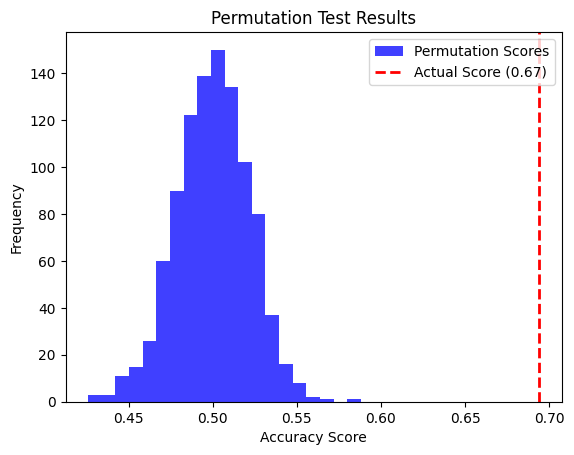

In [95]:

print(f'\n\n____________seed {seed_indes}______________\n samples',df_expanded.shape[0])
X = df_expanded.drop(columns=['subject', 'time_segment', 'begin_attitude', 'after_attitude', 'change','if_change','type'])  # 特征是功能连接的列
y = df_expanded['if_change']  # 目标是态度数据

svm_model = SVC(class_weight='balanced')
score, permutation_scores, pvalue = permutation_test_score(
    svm_model, X, y, cv=kfold, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)

print(f"置换检验得分: {score:.2f}")
print(f"置换检验的p值: {pvalue:.4f}")

y_pred = cross_val_predict(svm_model, X, y, cv=loo)
accuracy = accuracy_score(y, y_pred)
# 计算混淆矩阵
conf_matrix = confusion_matrix(y, y_pred)

# 输出混淆矩阵
print("混淆矩阵:")
print(conf_matrix)

# 输出详细的分类报告（精确率、召回率、F1-score）
print("分类报告:")
print(classification_report(y, y_pred))

# 可视化置换检验结果
plt.hist(permutation_scores, bins=20, alpha=0.75, color='blue', label='Permutation Scores')
plt.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Actual Score ({score:.2f})')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('Permutation Test Results')
plt.legend(loc='best')
plt.show()

In [97]:
accuracy

0.6940540540540541

## DMN

In [100]:
df.head()

,subject,time_segment,begin_attitude,after_attitude,change,if_change,type,0,1,2,...,189,190,191,192,193,194,195,196,197,198
0,0,0,12,12,0,0,None,-0.430392,-0.196602,-0.015653,...,0.312162,0.747290,0.667708,-0.130048,-0.198474,0.032947,0.007310,-0.073283,-0.111916,0.363747
1,1,0,10,10,0,0,None,-0.037642,-0.049698,-0.100152,...,-0.117250,0.451144,0.645362,0.380709,-0.022658,0.296430,0.039280,-0.011718,0.125541,0.025248
2,2,0,2,1,-1,1,None,-0.248057,-0.317796,-0.165081,...,-0.100692,0.220274,0.158607,0.329798,0.002796,0.145099,-0.126526,-0.242119,0.007791,0.268040
3,3,0,4,4,0,0,None,-0.174485,0.001950,0.000170,...,0.029049,0.358953,0.446784,0.204979,0.217267,0.170297,-0.400899,0.079724,-0.018689,0.094039
4,4,0,5,8,3,1,None,-0.278219,-0.211346,-0.155404,...,0.323047,0.585997,0.554326,0.182441,0.015380,0.634288,0.670350,-0.145149,0.372390,0.244020


In [112]:
nw_labels = pd.read_csv('/Users/li/Desktop/template/Schaefer/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
nw_labels = nw_labels[nw_labels["ROI Label"] != 90].reset_index(drop=True)

default = []
for i in range(199):
    net_name = nw_labels['ROI Name'][i].split('_')[2] 
    if net_name == 'Default':
        default.append(i)
        
print(default)
selete_edge = ['if_change'] + default # 

df_DMN = df[selete_edge]
df_DMN.head()

[73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]


,if_change,73,74,75,76,77,78,79,80,81,...,189,190,191,192,193,194,195,196,197,198
0,0,-0.652570,-0.361554,-0.636624,-0.611936,-0.619443,-0.600688,-0.170339,-0.511564,-0.369900,...,0.312162,0.747290,0.667708,-0.130048,-0.198474,0.032947,0.007310,-0.073283,-0.111916,0.363747
1,0,-0.119271,0.026810,-0.229655,-0.340875,-0.214475,-0.154727,0.048724,0.200283,-0.005309,...,-0.117250,0.451144,0.645362,0.380709,-0.022658,0.296430,0.039280,-0.011718,0.125541,0.025248
2,1,-0.271926,-0.269108,-0.384206,-0.072639,-0.458144,-0.427033,-0.336871,-0.122209,-0.126744,...,-0.100692,0.220274,0.158607,0.329798,0.002796,0.145099,-0.126526,-0.242119,0.007791,0.268040
3,0,-0.149531,-0.275912,-0.097097,0.112658,0.064575,-0.121516,-0.258869,0.338866,-0.270195,...,0.029049,0.358953,0.446784,0.204979,0.217267,0.170297,-0.400899,0.079724,-0.018689,0.094039
4,1,-0.359561,-0.373714,-0.631255,-0.289795,-0.376829,-0.348920,0.255368,-0.287544,0.020031,...,0.323047,0.585997,0.554326,0.182441,0.015380,0.634288,0.670350,-0.145149,0.372390,0.244020


置换检验得分: 0.64
置换检验的p值: 0.0010
loo正确率： 0.6486486486486487
混淆矩阵:
[[321 155]
 [170 279]]
分类报告:
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       476
           1       0.64      0.62      0.63       449

    accuracy                           0.65       925
   macro avg       0.65      0.65      0.65       925
weighted avg       0.65      0.65      0.65       925



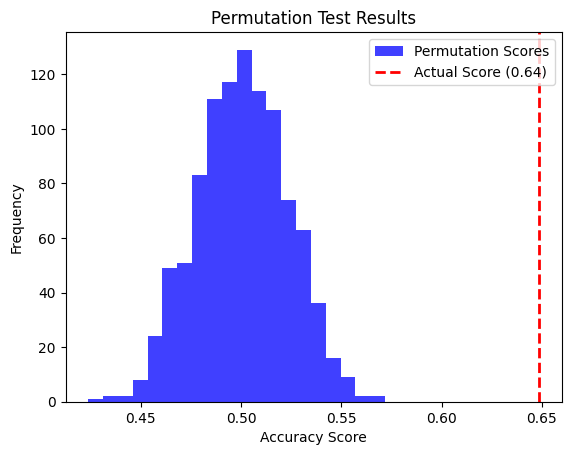

In [114]:

X = df_DMN.drop(columns=['if_change'])  # 特征是功能连接的列
y = df_DMN['if_change']  # 目标是态度数据

svm_model = SVC(class_weight='balanced')
score, permutation_scores, pvalue = permutation_test_score(
    svm_model, X, y, cv=kfold, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)

print(f"置换检验得分: {score:.2f}")
print(f"置换检验的p值: {pvalue:.4f}")

y_pred = cross_val_predict(svm_model, X, y, cv=loo)
accuracy = accuracy_score(y, y_pred)
print("loo正确率：", accuracy)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y, y_pred)

# 输出混淆矩阵
print("混淆矩阵:")
print(conf_matrix)

# 输出详细的分类报告（精确率、召回率、F1-score）
print("分类报告:")
print(classification_report(y, y_pred))

# 可视化置换检验结果
plt.hist(permutation_scores, bins=20, alpha=0.75, color='blue', label='Permutation Scores')
plt.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Actual Score ({score:.2f})')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('Permutation Test Results')
plt.legend(loc='best')
plt.show()

## 5 type

In [ ]:

def set_y(row):
    if row['begin_attitude'] > 7 and row['change'] > 0:
        return 1
    elif row['begin_attitude'] > 7 and row['change'] < 0:
        return 2
    elif row['begin_attitude'] < 7 and row['change'] < 0:
        return 3
    elif row['begin_attitude'] < 7 and row['change'] > 0:
        return 4
    else:
        return 0 
        
seeds_index_list = [89]
data = all_brain_data

for seed_indes in seeds_index_list:
    brain_area_index = seed_indes
    results = []
    for i in range(len(TR_points) - 1):
        start = TR_points[i]
        end = TR_points[i + 1]
        
        # 提取每个被试在当前时间段的数据
        for subject in range(data.shape[0]):
            segment = data[subject, start:end, :]
            
            # 计算功能连接
            correlation_matrix = np.corrcoef(segment, rowvar=False)
            correlations = correlation_matrix[brain_area_index, :]
            correlations = np.delete(correlations, brain_area_index)
    
            begin_attitude = attitude[subject, i]
            after_attitude = attitude[subject, i+1]
            change = after_attitude - begin_attitude
            # 存储结果
            results.append({
                'subject': subject,
                'time_segment': i,
                'connectivity': correlations,
                'begin_attitude': begin_attitude,
                'after_attitude': after_attitude,
                'change': change,
                'type': None})
    # 创建功能连接的 DataFrame
    df = pd.DataFrame(results)
    df = df.drop(columns='connectivity').join(pd.DataFrame(df['connectivity'].tolist(), index=df.index)) 
    df_expanded = df.copy()      
    df_expanded['type'] = df_expanded.apply(set_y, axis=1)
    df_expanded = df_expanded.dropna(subset=['type'])
    
    print(f'\n\n____________seed {seed_indes}______________\n samples',df_expanded.shape[0])
    X = df_expanded.drop(columns=['subject', 'time_segment', 'begin_attitude', 'after_attitude', 'change','type'])  # 特征是功能连接的列
    y = df_expanded['type']  # 目标是态度数据
    
    svm_model = SVC(class_weight='balanced')
    score, permutation_scores, pvalue = permutation_test_score(
        svm_model, X, y, cv=kfold, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)
    
    print(f"置换检验得分: {score:.2f}")
    print(f"置换检验的p值: {pvalue:.4f}")
    
    y_pred = cross_val_predict(svm_model, X, y, cv=loo)
    accuracy = accuracy_score(y, y_pred)
    # 计算混淆矩阵
    conf_matrix = confusion_matrix(y, y_pred)
    
    # 输出混淆矩阵
    print("混淆矩阵:")
    print(conf_matrix)
    
    # 输出详细的分类报告（精确率、召回率、F1-score）
    print("分类报告:")
    print(classification_report(y, y_pred))

    # 可视化置换检验结果
    plt.hist(permutation_scores, bins=20, alpha=0.75, color='blue', label='Permutation Scores')
    plt.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Actual Score ({score:.2f})')
    plt.xlabel('Accuracy Score')
    plt.ylabel('Frequency')
    plt.title('Permutation Test Results')
    plt.legend(loc='best')
    plt.show()

## 4 type

In [ ]:

def set_y(row):
    if row['begin_attitude'] > 7 and row['change'] > 0:
        return 1
    elif row['begin_attitude'] > 7 and row['change'] < 0:
        return 2
    elif row['begin_attitude'] < 7 and row['change'] < 0:
        return 3
    elif row['begin_attitude'] < 7 and row['change'] > 0:
        return 4
    else:
        return 0 
        
seeds_index_list = [89]
data = all_brain_data

for seed_indes in seeds_index_list:
    brain_area_index = seed_indes
    results = []
    for i in range(len(TR_points) - 1):
        start = TR_points[i]
        end = TR_points[i + 1]
        
        # 提取每个被试在当前时间段的数据
        for subject in range(data.shape[0]):
            segment = data[subject, start:end, :]
            
            # 计算功能连接
            correlation_matrix = np.corrcoef(segment, rowvar=False)
            correlations = correlation_matrix[brain_area_index, :]
            correlations = np.delete(correlations, brain_area_index)
    
            begin_attitude = attitude[subject, i]
            after_attitude = attitude[subject, i+1]
            change = after_attitude - begin_attitude
            # 存储结果
            results.append({
                'subject': subject,
                'time_segment': i,
                'connectivity': correlations,
                'begin_attitude': begin_attitude,
                'after_attitude': after_attitude,
                'change': change,
                'type': None})
    # 创建功能连接的 DataFrame
    df = pd.DataFrame(results)
    df = df.drop(columns='connectivity').join(pd.DataFrame(df['connectivity'].tolist(), index=df.index)) 
    df_expanded = df.copy()      
    df_expanded['type'] = df_expanded.apply(set_y, axis=1)
    df_expanded = df_expanded.dropna(subset=['type'])
    
    print(f'\n\n____________seed {seed_indes}______________\n samples',df_expanded.shape[0])
    X = df_expanded.drop(columns=['subject', 'time_segment', 'begin_attitude', 'after_attitude', 'change','type'])  # 特征是功能连接的列
    y = df_expanded['type']  # 目标是态度数据
    
    svm_model = SVC(class_weight='balanced')
    score, permutation_scores, pvalue = permutation_test_score(
        svm_model, X, y, cv=kfold, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)
    
    print(f"置换检验得分: {score:.2f}")
    print(f"置换检验的p值: {pvalue:.4f}")
    
    y_pred = cross_val_predict(svm_model, X, y, cv=loo)
    accuracy = accuracy_score(y, y_pred)
    # 计算混淆矩阵
    conf_matrix = confusion_matrix(y, y_pred)
    
    # 输出混淆矩阵
    print("混淆矩阵:")
    print(conf_matrix)
    
    # 输出详细的分类报告（精确率、召回率、F1-score）
    print("分类报告:")
    print(classification_report(y, y_pred))

    # 可视化置换检验结果
    plt.hist(permutation_scores, bins=20, alpha=0.75, color='blue', label='Permutation Scores')
    plt.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Actual Score ({score:.2f})')
    plt.xlabel('Accuracy Score')
    plt.ylabel('Frequency')
    plt.title('Permutation Test Results')
    plt.legend(loc='best')
    plt.show()

In [ ]:
def set_y(row):
    if row['begin_attitude'] > 7 and row['change'] > 0:
        return 1
    elif row['begin_attitude'] > 7 and row['change'] < 0:
        return 2
    elif row['begin_attitude'] < 7 and row['change'] < 0:
        return 3
    elif row['begin_attitude'] < 7 and row['change'] > 0:
        return 4
    else:
        return None

seeds_index_list = [89]

data = all_brain_data

for seed_indes in seeds_index_list:
    
    brain_area_index = seed_indes
    
    results = []
    
    for i in range(len(TR_points) - 1):
        start = TR_points[i]
        end = TR_points[i + 1]
        
        # 提取每个被试在当前时间段的数据
        for subject in range(data.shape[0]):
            segment = data[subject, start:end, :]
            
            # 计算功能连接
            correlation_matrix = np.corrcoef(segment, rowvar=False)
            correlations = correlation_matrix[brain_area_index, :]
            correlations = np.delete(correlations, brain_area_index)
    
            begin_attitude = attitude[subject, i]
            after_attitude = attitude[subject, i+1]
            change = after_attitude - begin_attitude
            # 存储结果
            results.append({
                'subject': subject,
                'time_segment': i,
                'connectivity': correlations,
                'begin_attitude': begin_attitude,
                'after_attitude': after_attitude,
                'change': change,
                'type': None
                
            })
    
    # 创建功能连接的 DataFrame
    df = pd.DataFrame(results)
    
    # 将功能连接的数组展开成单独的列
    df = df.drop(columns='connectivity').join(pd.DataFrame(df['connectivity'].tolist(), index=df.index))
    
    # 打印结果
    # print('df.shape:', df.shape)
    
    df_expanded = df.copy()
    
            
    df_expanded['type'] = df_expanded.apply(set_y, axis=1)
    
    df_expanded = df_expanded.dropna(subset=['type'])
    
    print(df_expanded.shape)
    
    X = df_expanded.drop(columns=['subject', 'time_segment', 'begin_attitude', 'after_attitude', 'change','type'])  # 特征是功能连接的列
    y = df_expanded['type']  # 目标是态度数据

    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    
    svm_model = SVC(class_weight='balanced')

    score, permutation_scores, pvalue = permutation_test_score(
        svm_model, X, y, cv=cv, n_permutations=5000, n_jobs=-1, scoring="accuracy", random_state=42
    )
    
    print(f"seed {seed_indes}\n\n置换检验得分: {score:.2f}")
    print(f"置换检验的p值: {pvalue:.4f}")
    y_pred = cross_val_predict(svm_model, X, y, cv=cv)
    
    # 计算混淆矩阵
    conf_matrix = confusion_matrix(y, y_pred)
    
    # 输出混淆矩阵
    print("混淆矩阵:")
    print(conf_matrix)
    
    # 输出详细的分类报告（精确率、召回率、F1-score）
    print("分类报告:")
    print(classification_report(y, y_pred))

    # 可视化置换检验结果
    plt.hist(permutation_scores, bins=20, alpha=0.75, color='grey', label='Permutation Scores')
    plt.axvline(score, color='red', linestyle='--', linewidth=2, label=f'Actual Score ({score:.2f})')
    plt.xlabel('Accuracy Score')
    plt.ylabel('Frequency')
    plt.title('Permutation Test Results')
    plt.legend(loc='best')
    plt.show()

In [ ]:
df_expanded

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:


seeds_index_list = [89]

data = all_brain_data

for seed_indes in seeds_index_list:
    
    brain_area_index = seed_indes
    
    results = []
    
    for i in range(len(TR_points) - 1):
        start = TR_points[i]
        end = TR_points[i + 1]
        
        # 提取每个被试在当前时间段的数据
        for subject in range(data.shape[0]):
            segment = data[subject, start:end, :]
            
            # 计算功能连接
            correlation_matrix = np.corrcoef(segment, rowvar=False)
            correlations = correlation_matrix[brain_area_index, :]
            correlations = np.delete(correlations, brain_area_index)
    
            begin_attitude = attitude[subject, i]
            after_attitude = attitude[subject, i+1]
            change = after_attitude - begin_attitude
            # 存储结果
            results.append({
                'subject': subject,
                'time_segment': i,
                'connectivity': correlations,
                'begin_attitude': begin_attitude,
                'after_attitude': after_attitude,
                'change': change,
                'unsignal change': np.abs(change),
                'type': None
                
            })
    
    # 创建功能连接的 DataFrame
    df = pd.DataFrame(results)
    
    # 将功能连接的数组展开成单独的列
    df = df.drop(columns='connectivity').join(pd.DataFrame(df['connectivity'].tolist(), index=df.index))
    
    # 打印结果
    # print('df.shape:', df.shape)
    
    df_expanded = df.copy()
    
    def set_y(row):
        if row['begin_attitude'] > 7 and row['change'] > 0:
            return 1
        elif row['begin_attitude'] > 7 and row['change'] < 0:
            return 2
        elif row['begin_attitude'] < 7 and row['change'] < 0:
            return 3
        elif row['begin_attitude'] < 7 and row['change'] > 0:
            return 4
        else:
            return None  
            
    df_expanded['type'] = df_expanded.apply(set_y, axis=1)
    
    # 删去df中没变的片段
    df_expanded = df_expanded.dropna(subset=['type'])
    
    print(df_expanded.shape)
    

    # 特征和目标
    X = df_expanded.drop(columns=['subject', 'time_segment', 'begin_attitude', 'after_attitude', 'change','unsignal change','type'])  # 特征是功能连接的列
    y = df_expanded['unsignal change']  # 目标是态度数据，确保目标是连续的
    
    # 创建交叉验证对象，注意SVR适用于回归任务
    cv = KFold(n_splits=8, shuffle=True, random_state=42)
    
    # 使用SVR代替SVC
    svm_model = SVR()
    
    # 使用置换检验进行模型评估
    score, permutation_scores, pvalue = permutation_test_score(
        svm_model, X, y, cv=cv, n_permutations=1000, n_jobs=-1, scoring="neg_mean_squared_error", random_state=42
    )
    
    print(f"置换检验得分: {score:.2f}")
    print(f"置换检验的p值: {pvalue:.4f}")
    
    # 预测结果
    y_pred = cross_val_predict(svm_model, X, y, cv=cv)
    
    # 计算回归模型的评估指标
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    
    # 输出回归评估指标
    print(f"均方误差 (MSE): {mse:.2f}")
    print(f"平均绝对误差 (MAE): {mae:.2f}")
    
    # 可视化置换检验结果
    plt.hist(permutation_scores, bins=20, alpha=0.75, color='grey', label='Permutation Scores')
    plt.axvline(score, color='red', linestyle='--', linewidth=2, label=f'Actual Score ({score:.2f})')
    plt.xlabel('Negative Mean Squared Error')
    plt.ylabel('Frequency')
    plt.title('Permutation Test Results')
    plt.legend(loc='best')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 预测结果
y_pred = cross_val_predict(svm_model, X, y, cv=cv)

# 绘制真实值与预测值的散点图
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, color='blue', alpha=0.5)  # 使用蓝色表示每个点
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')  # 绘制y = x的参考线
plt.xlabel('真实值 (True Values)')
plt.ylabel('预测值 (Predicted Values)')
plt.title('真实值与预测值的散点图')
plt.show()


In [ ]:
from scipy.stats import pearsonr

# 计算皮尔逊相关系数
correlation, _ = pearsonr(y, y_pred)

print(f"真实值与预测值的皮尔逊相关系数: {correlation:.4f}")
